# 일본 삿포로시 날씨, 대기질 데이터 분석

삿포로시에서 일하는 친구가 있음.  
본인도 해외취업에 관심이 있고 일본도 관심 국가 중 하나이기 때문에 일본을 주제로 함.

## 1. 데이터 Load

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
weather_df = pd.read_excel("../data/weather_sapporo.xlsx")
display(weather_df)
print(weather_df.shape)

air_df = pd.read_excel("../data/air_sapporo.xlsx")
display(air_df)
print(air_df.shape)

,date,temperature,rain,wind,humid
0,2025/3/1 1:00:00,7.4,0.0,2.9,59
1,2025/3/1 2:00:00,7.3,0.0,3.8,55
2,2025/3/1 3:00:00,5.2,0.0,0.7,62
3,2025/3/1 4:00:00,3.4,0.0,1.1,75
4,2025/3/1 5:00:00,2.9,0.0,1.2,78
...,...,...,...,...,...
739,2025/3/31 20:00:00,1.0,0.0,3.5,63
740,2025/3/31 21:00:00,0.7,0.0,2.2,64
741,2025/3/31 22:00:00,0.7,0.0,1.4,66
742,2025/3/31 23:00:00,0.4,0.0,2.3,68


(744, 5)


,date,time,SO2,CO,Ox,THC,SPM,PM2.5
0,2025-03-01,1,0,0.3,0.067,2.22,0.041,28
1,2025-03-01,2,0,0.3,0.062,2.24,0.036,39
2,2025-03-01,3,0.001,0.4,0.033,2.38,0.034,29
3,2025-03-01,4,0.001,0.4,0.016,2.57,0.036,36
4,2025-03-01,5,0.001,0.4,0.010,2.66,0.035,36
...,...,...,...,...,...,...,...,...
739,2025-03-31,20,0.001,0.2,0.043,2.13,0.009,10
740,2025-03-31,21,0,0.2,0.044,2.12,0.010,7
741,2025-03-31,22,0,0.2,0.044,2.14,0.012,11
742,2025-03-31,23,0,0.2,0.043,2.14,0.012,6


(744, 8)


## 2. 데이터 전처리

### 2-1. date 형식 변환

두 데이터 모두 date 컬럼이 object 타입으로 되어 있음.  
인덱스를 기준으로 병합할 계획이니 하나의 데이터만 date 타입으로 변환하려 함.

In [3]:
air_df["date"] = pd.to_datetime(air_df["date"])
print(air_df.dtypes)

date     datetime64[ns]
time              int64
SO2              object
CO               object
Ox               object
THC              object
SPM              object
PM2.5            object
dtype: object


### 2-2. 데이터 형식 변환

미세먼지 데이터에 int형이어야 할 데이터가 object형으로 되어 있어 변환하려 함.

In [5]:
print(air_df.dtypes)

date     datetime64[ns]
time              int64
SO2              object
CO               object
Ox               object
THC              object
SPM              object
PM2.5            object
dtype: object


결측치가 '-'로 저장되어 있어 float형으로 변환이 불가능하였음.  
따라서 아래의 코드로 NaN으로 변환 후 float형으로 변환.

In [6]:
air_df.replace('-', np.nan, inplace=True)

air_df[["SO2", "CO", "Ox", "THC", "SPM", "PM2.5"]] = air_df[["SO2", "CO", "Ox", "THC", "SPM", "PM2.5"]].astype("float64")
print(air_df.dtypes)

date     datetime64[ns]
time              int64
SO2             float64
CO              float64
Ox              float64
THC             float64
SPM             float64
PM2.5           float64
dtype: object


### 2-3. 이상치 확인

그래프를 표시하던 중 "PM2.5" 데이터에 음수가 있는 것을 확인하였음.  
미세먼지나 오염물질의 농도가 음수가 될 수는 없으니 이상치로 판단하고 처리하기로 함.  
스스로 해결이 안 되어 LLM의 힘을 빌렸음.

In [7]:
# 이상치 확인
air_df[air_df[["SO2", "CO", "Ox", "THC", "SPM", "PM2.5"]] < 0].dropna(how="all")
air_df["PM2.5"] = air_df["PM2.5"].clip(lower=0)

### 2-3. 결측치 확인

In [8]:
print(air_df.isna().sum())
print(weather_df.isna().sum())

date      0
time      0
SO2      32
CO        4
Ox        2
THC       2
SPM      30
PM2.5    49
dtype: int64
date           0
temperature    0
rain           0
wind           0
humid          0
dtype: int64


### 2-4. 결측치 처리

groupby를 사용하여 각 시간별 평균치로 결측치를 대체하려 함.

In [9]:
air_df.fillna(air_df.groupby("time").transform("mean"), inplace=True)

print(air_df.isna().sum())

date     0
time     0
SO2      0
CO       0
Ox       0
THC      0
SPM      0
PM2.5    0
dtype: int64


### 2-5. rain 데이터 변경

In [10]:
display(weather_df["rain"].value_counts())
weather_df["rain"].replace(0, 0.1, inplace=True)
display(weather_df["rain"].value_counts())

rain
0.0    627
0.5     80
1.0     19
1.5      8
2.0      7
2.5      1
3.0      1
4.0      1
Name: count, dtype: int64

C:\Users\AI-510-170\AppData\Local\Temp\ipykernel_11492\1482178.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather_df["rain"].replace(0, 0.1, inplace=True)


rain
0.1    627
0.5     80
1.0     19
1.5      8
2.0      7
2.5      1
3.0      1
4.0      1
Name: count, dtype: int64

## 3. 데이터 병합

겹치는 컬럼인 "date"를 weather에서 삭제하고 인덱스 기준으로 병합

In [11]:
weather_df.drop(columns=["date"], inplace=True)

df = air_df.join(weather_df)
display(df)

,date,time,SO2,CO,Ox,THC,SPM,PM2.5,temperature,rain,wind,humid
0,2025-03-01,1,0.000,0.3,0.067,2.22,0.041,28.0,7.4,0.1,2.9,59
1,2025-03-01,2,0.000,0.3,0.062,2.24,0.036,39.0,7.3,0.1,3.8,55
2,2025-03-01,3,0.001,0.4,0.033,2.38,0.034,29.0,5.2,0.1,0.7,62
3,2025-03-01,4,0.001,0.4,0.016,2.57,0.036,36.0,3.4,0.1,1.1,75
4,2025-03-01,5,0.001,0.4,0.010,2.66,0.035,36.0,2.9,0.1,1.2,78
...,...,...,...,...,...,...,...,...,...,...,...,...
739,2025-03-31,20,0.001,0.2,0.043,2.13,0.009,10.0,1.0,0.1,3.5,63
740,2025-03-31,21,0.000,0.2,0.044,2.12,0.010,7.0,0.7,0.1,2.2,64
741,2025-03-31,22,0.000,0.2,0.044,2.14,0.012,11.0,0.7,0.1,1.4,66
742,2025-03-31,23,0.000,0.2,0.043,2.14,0.012,6.0,0.4,0.1,2.3,68


## 4. 데이터 분석 및 시각화

### 4-1. 데이터 상관계수 확인

In [12]:
corr = df.corr()
display(corr)

display(corr["PM2.5"].sort_values(ascending=False))

,date,time,SO2,CO,Ox,THC,SPM,PM2.5,temperature,rain,wind,humid
date,1.000000e+00,-9.468518e-15,-0.150716,-0.115680,0.147790,-0.166067,-0.049974,-0.059473,0.317803,-0.008631,-0.016920,0.041390
time,-9.468518e-15,1.000000e+00,-0.106704,-0.016353,0.141375,-0.100105,-0.035318,0.037310,0.104633,-0.021297,0.031998,-0.097424
SO2,-1.507165e-01,-1.067039e-01,1.000000,0.309952,-0.280170,0.179784,0.093028,-0.023837,-0.022216,-0.063309,-0.111941,-0.126735
CO,-1.156799e-01,-1.635327e-02,0.309952,1.000000,-0.559764,0.768030,0.471209,0.324053,0.129803,-0.087162,-0.322831,0.091951
Ox,1.477901e-01,1.413745e-01,-0.280170,-0.559764,1.000000,-0.622999,0.143671,0.159829,0.431588,0.046140,0.478724,-0.262493
THC,-1.660670e-01,-1.001053e-01,0.179784,0.768030,-0.622999,1.000000,0.421285,0.286980,0.046828,-0.069742,-0.371858,0.179367
SPM,-4.997438e-02,-3.531792e-02,0.093028,0.471209,0.143671,0.421285,1.000000,0.752821,0.490773,-0.144022,-0.087524,-0.096285
PM2.5,-5.947263e-02,3.730954e-02,-0.023837,0.324053,0.159829,0.286980,0.752821,1.000000,0.327671,-0.079830,-0.128102,0.010900
temperature,3.178027e-01,1.046335e-01,-0.022216,0.129803,0.431588,0.046828,0.490773,0.327671,1.000000,-0.095729,0.222454,-0.257651
rain,-8.631442e-03,-2.129686e-02,-0.063309,-0.087162,0.046140,-0.069742,-0.144022,-0.079830,-0.095729,1.000000,0.113162,0.392287


PM2.5          1.000000
SPM            0.752821
temperature    0.327671
CO             0.324053
THC            0.286980
Ox             0.159829
time           0.037310
humid          0.010900
SO2           -0.023837
date          -0.059473
rain          -0.079830
wind          -0.128102
Name: PM2.5, dtype: float64

### 4-2. 히스토그램 시각화

array([[<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'time'}>,
        <Axes: title={'center': 'SO2'}>],
       [<Axes: title={'center': 'CO'}>, <Axes: title={'center': 'Ox'}>,
        <Axes: title={'center': 'THC'}>],
       [<Axes: title={'center': 'SPM'}>,
        <Axes: title={'center': 'PM2.5'}>,
        <Axes: title={'center': 'temperature'}>],
       [<Axes: title={'center': 'rain'}>,
        <Axes: title={'center': 'wind'}>,
        <Axes: title={'center': 'humid'}>]], dtype=object)

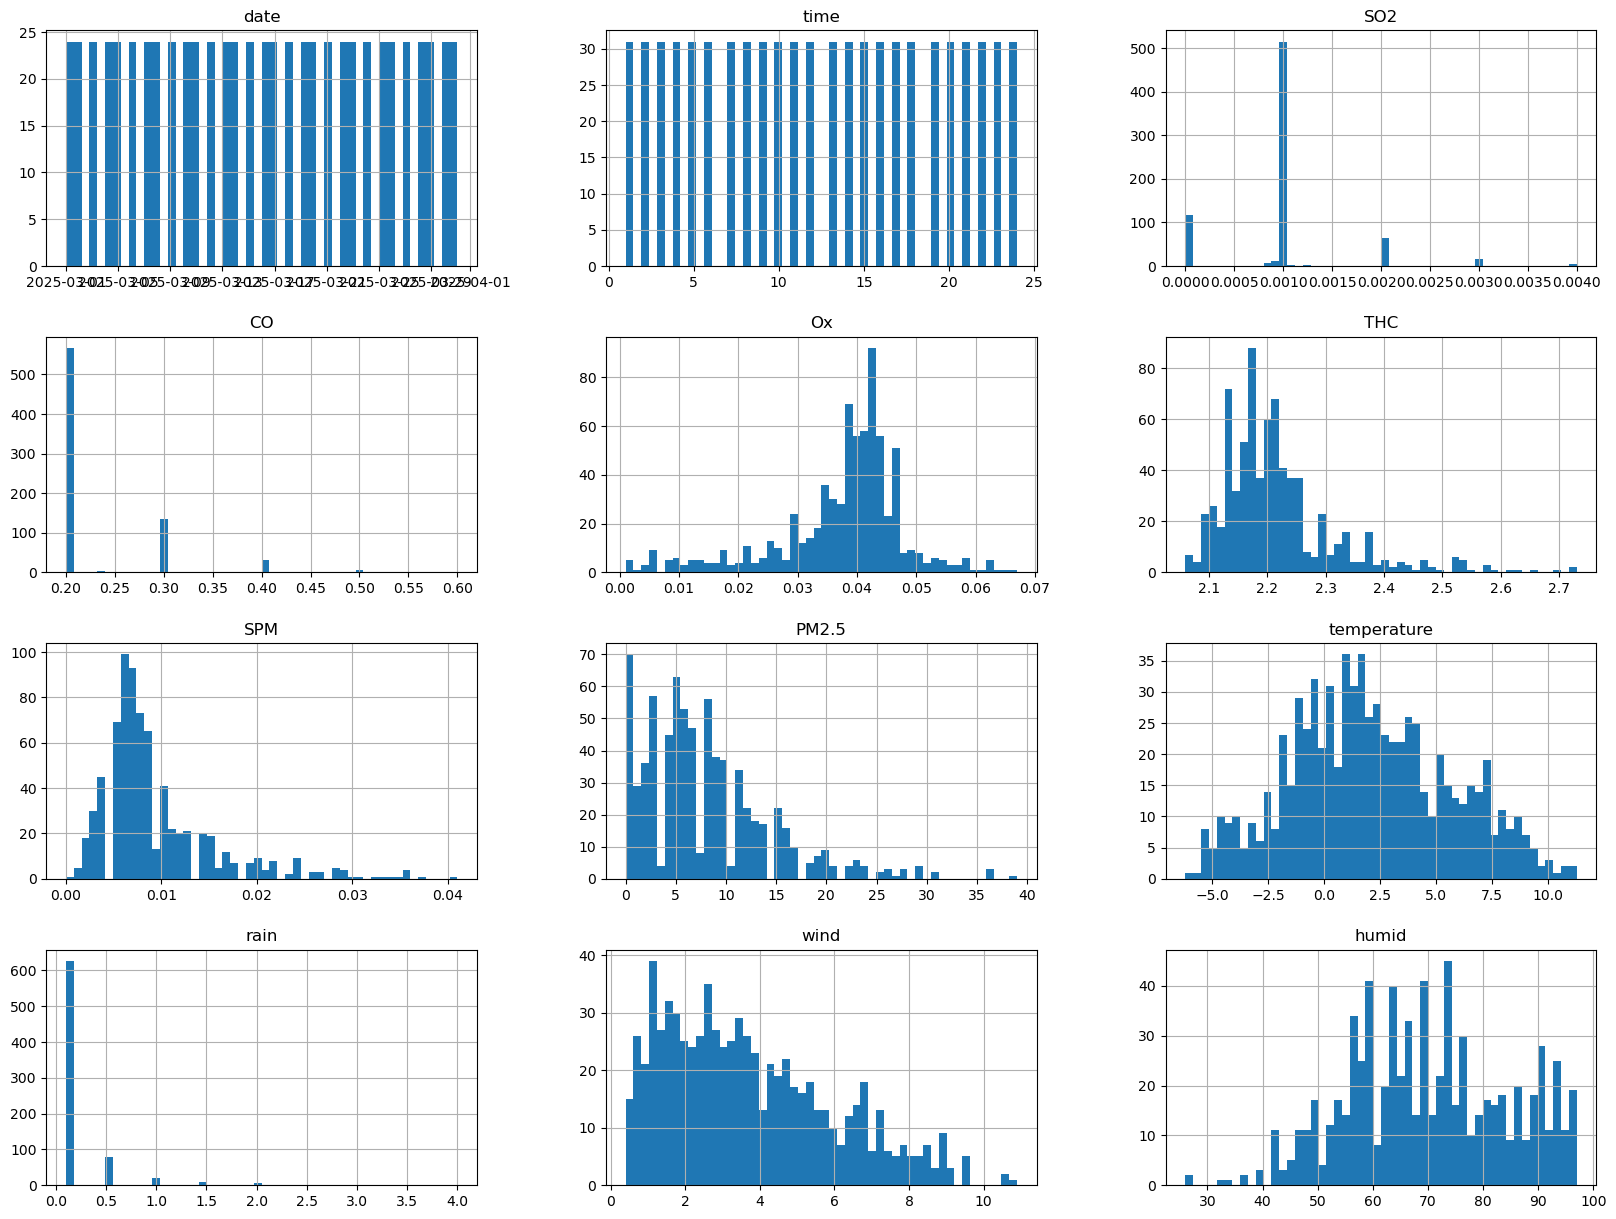

In [13]:
df.hist(bins=50, figsize=(20,15))

### 4-3. 막대그래프 시각화

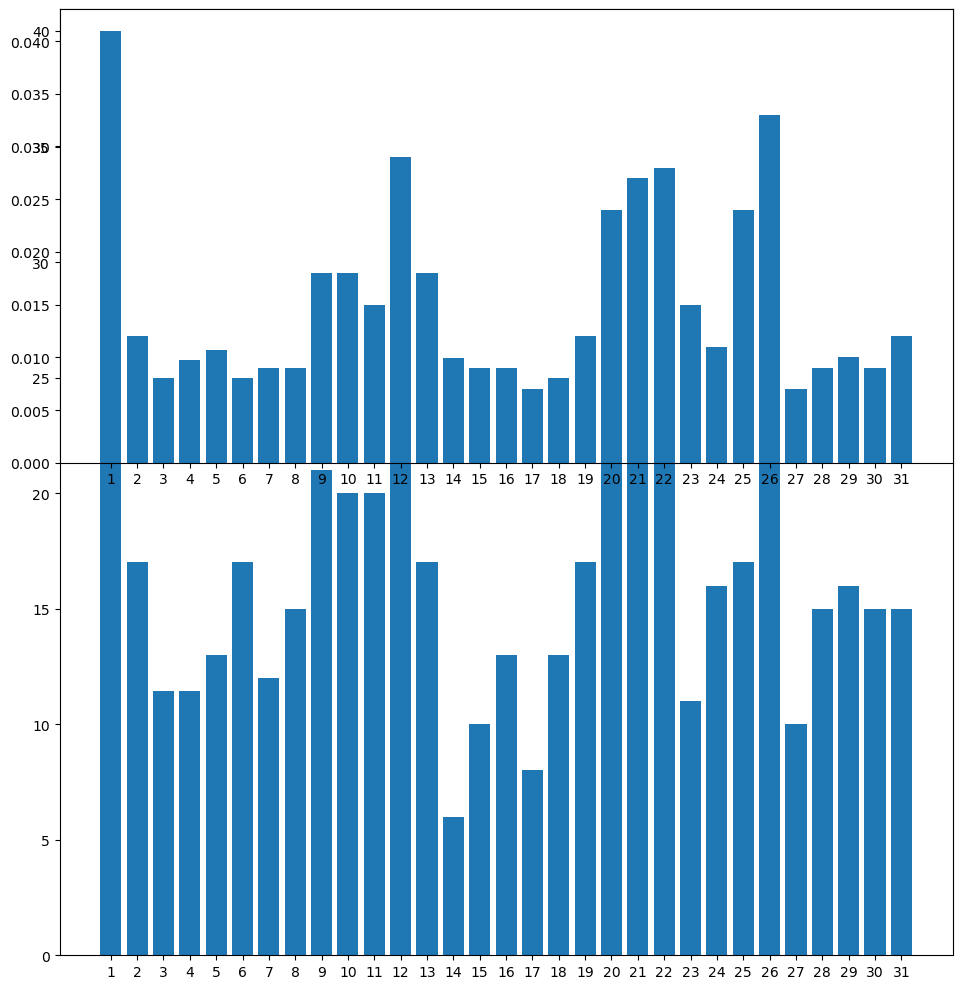

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title("PM2.5")
plt.bar(df["date"].dt.day, df["PM2.5"]) # 날짜를 표시하고 싶어서 dt.day를 사용함
plt.xticks(range(1,32))
plt.tight_layout()
plt.subplot(2,1,2)
plt.title("SPM")
plt.bar(df["date"].dt.day, df["SPM"])
plt.xticks(range(1,32))
plt.tight_layout()
plt.show()

### 4-4. 히트맵 시각화

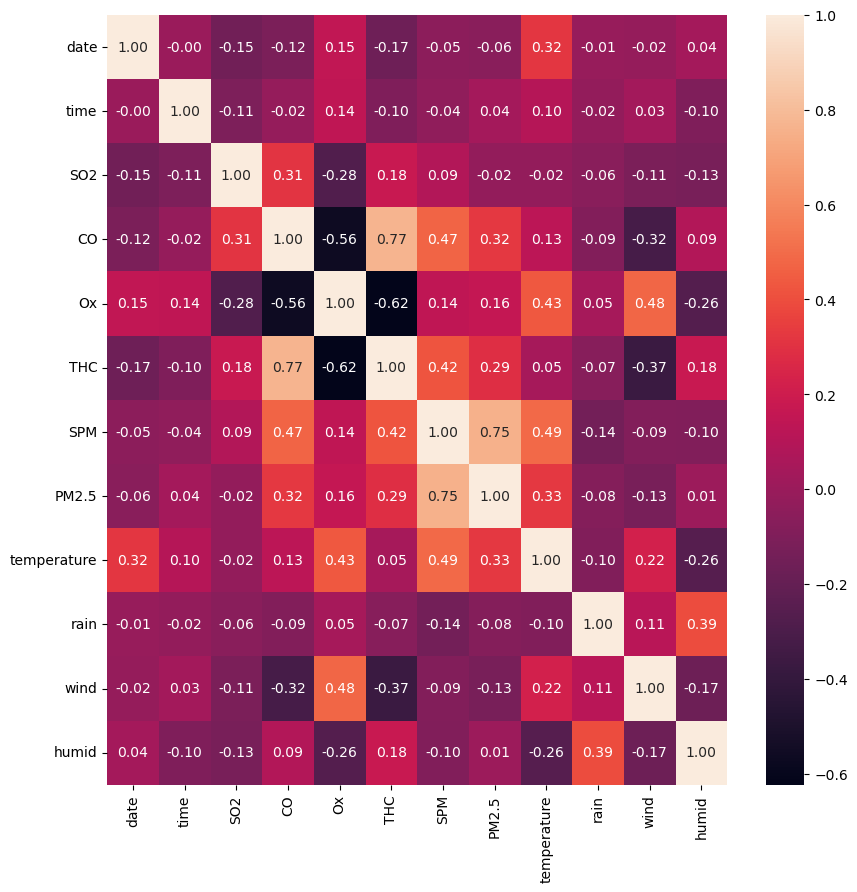

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(data=corr, annot=True, fmt=".2f")
plt.show()

### 4-5. 산점도 그래프 시각화

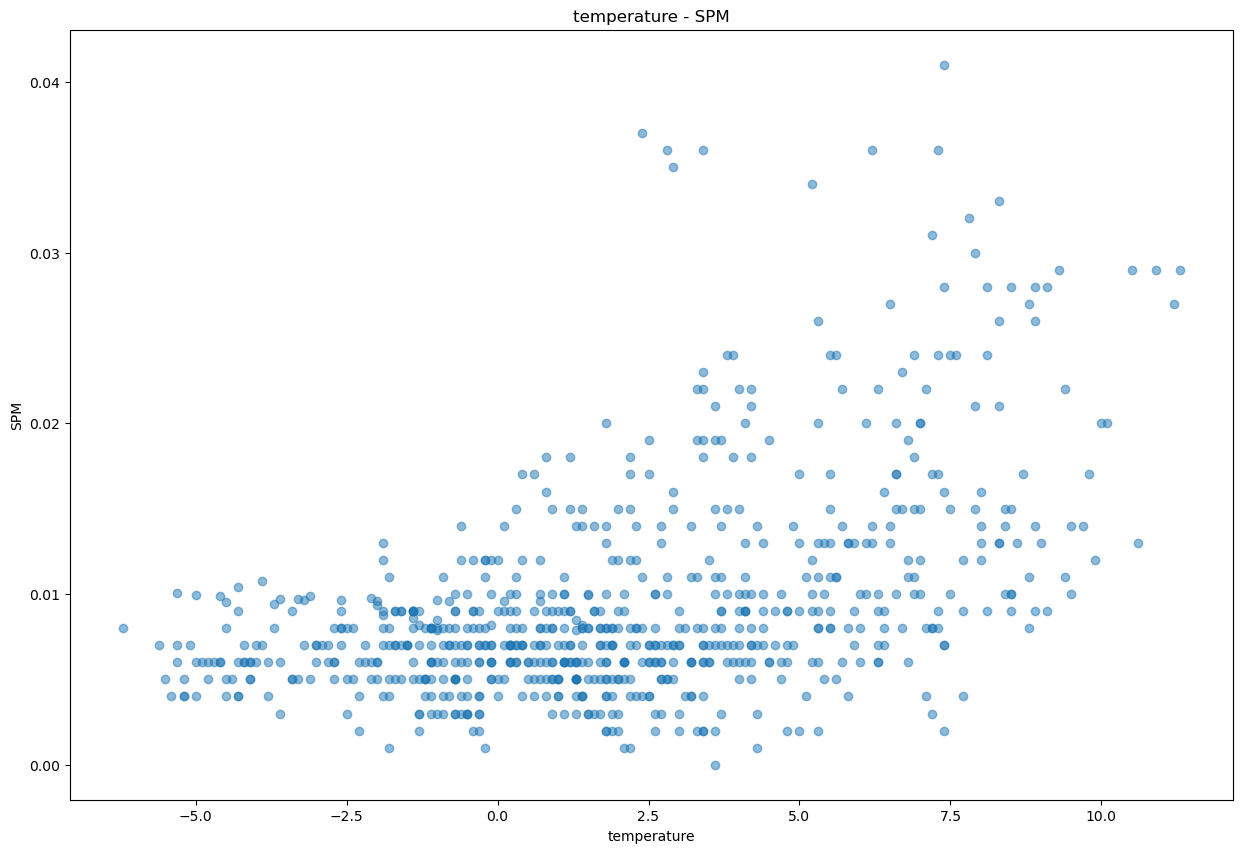

In [16]:
plt.figure(figsize=(15,10))
x = df["temperature"]
y = df["SPM"]
plt.scatter(x, y, alpha=0.5)
plt.title("temperature - SPM")
plt.xlabel("temperature")
plt.ylabel("SPM")
plt.show()

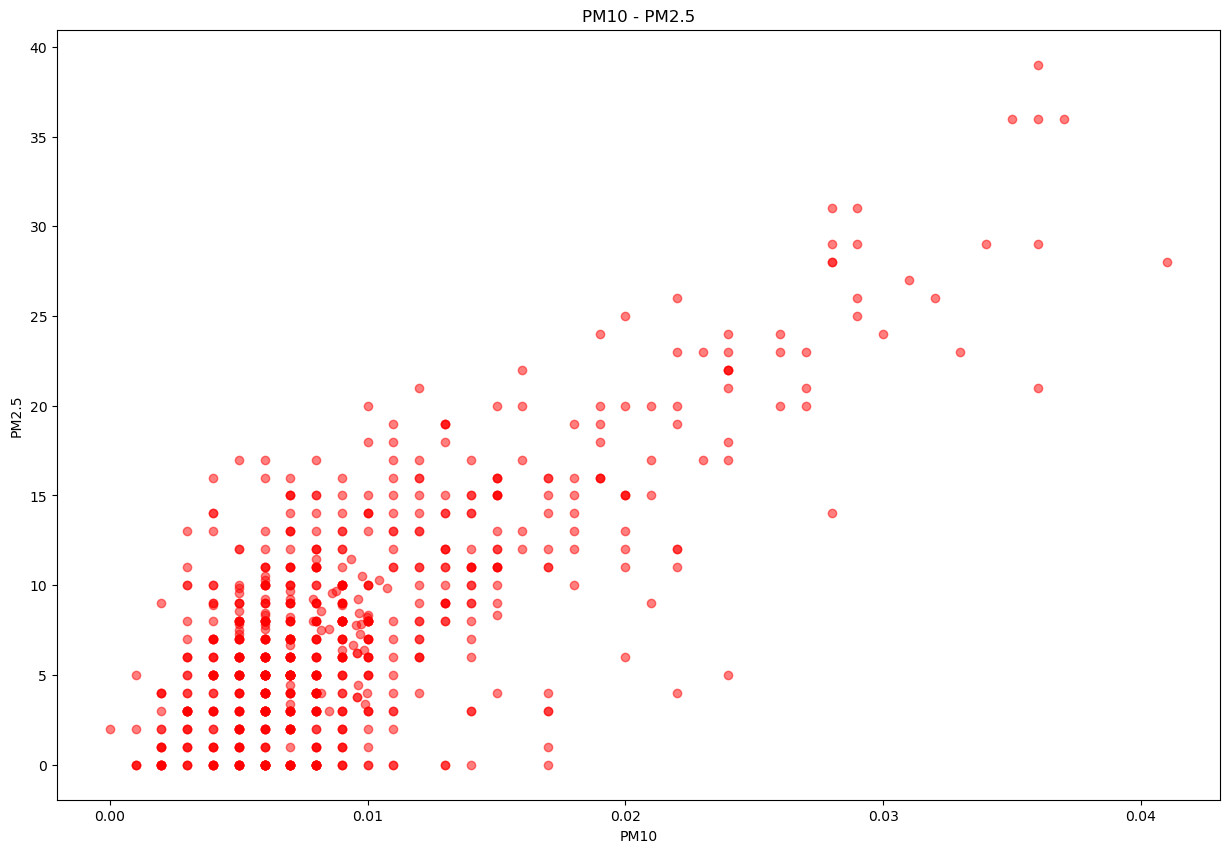

In [17]:
plt.figure(figsize=(15,10))
x = df["SPM"]
y = df["PM2.5"]
plt.scatter(x, y, color="red", alpha=0.5)
plt.title("PM10 - PM2.5")
plt.xlabel("PM10")
plt.ylabel("PM2.5")
plt.show()